In [33]:
from PIL import Image

In [34]:
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [35]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [36]:
print(torch.cuda.is_available())

True


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [38]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

In [55]:
# load content and style image
content = load_image('octopus.jpg').to(device)
style = load_image('hockney.jpg', shape=content.shape[-2:]).to(device)

In [56]:
# display tensor as image
# reverse of load_image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.299, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image
    

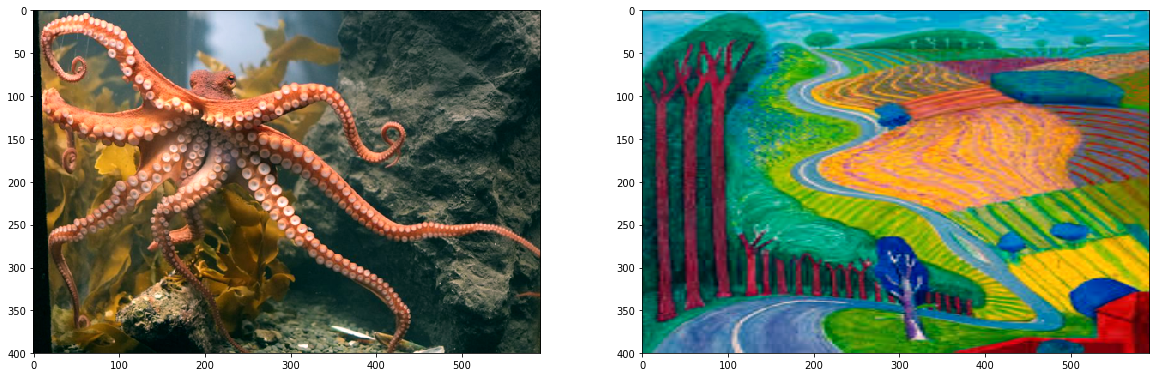

In [57]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [58]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        features = {}
        x = image
        # model._modules is a dictionary holding each module in the model
        for name, layer in model._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features
        

In [59]:
get_features(content, vgg)

{'conv1_1': tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 1.9715,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 5.3304,  0.2188,  0.0984,  ...,  0.0000,  0.0000,  0.0000],
           [ 5.4554,  0.2647,  0.1759,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 5.4234,  0.3223,  0.3071,  ...,  0.5864,  0.3903,  0.0000],
           [ 5.4501,  0.3289,  0.3289,  ...,  0.9083,  0.5569,  0.0000],
           [ 6.9304,  4.1062,  4.1062,  ...,  2.9152,  2.9054,  0.2850]],
 
          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
  

In [60]:
# calculating Gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [61]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

#clone target from content image and its weights will change
target = content.clone().requires_grad_(True).to(device)

In [62]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1 # alpha
style_weight = 1e6 # beta

Total loss:  733.9834594726562


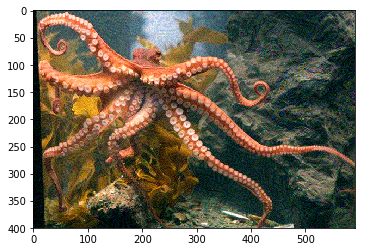

Total loss:  536.0445556640625


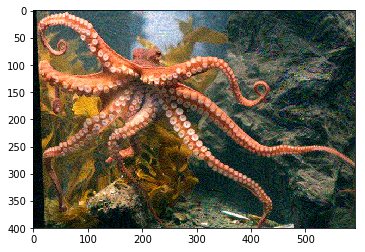

Total loss:  462.59246826171875


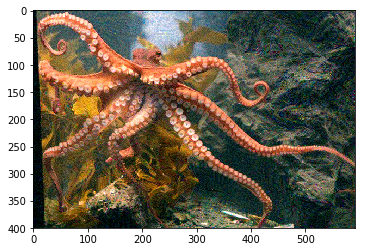

Total loss:  417.75958251953125


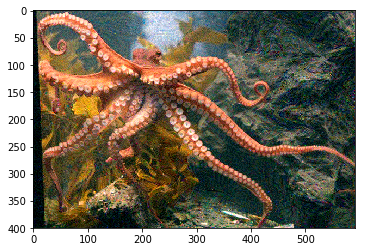

Total loss:  385.7129211425781


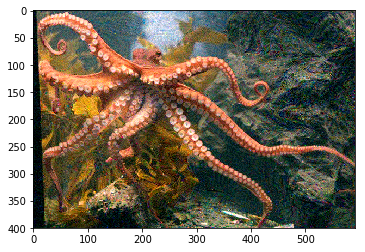

In [63]:
show_every = 400
optimizer = optim.Adam([target], lr=0.03)
steps = 2000
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    # content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    # style loss = 0
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram-style_gram)**2)
        style_loss = layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

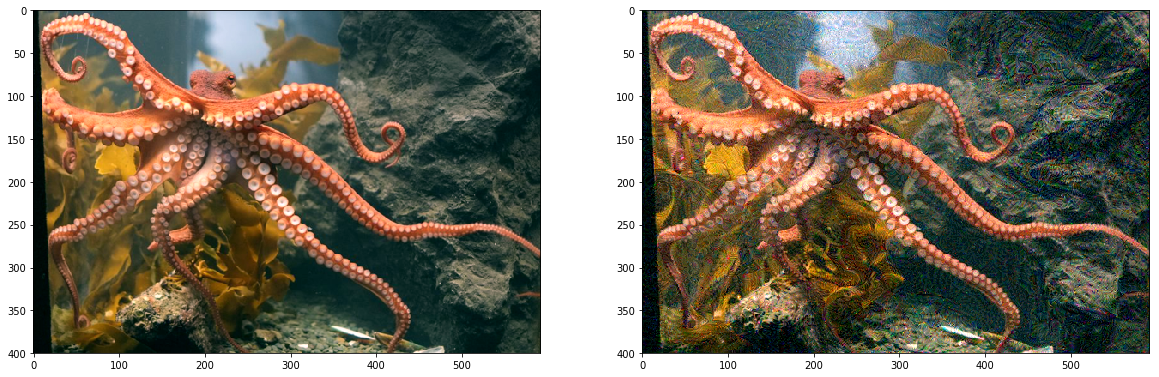

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))